In this notebook, your task is to build a sleep stage classification model for the [Haaglanden Medisch Centrum Sleep Staging Database](https://physionet.org/content/hmc-sleep-staging/1.1/) you examined in your last homework assignment.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install opencv-python
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
def colab2pdf():
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
    NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
    TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
    NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
    warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
    with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
    if not pathlib.Path("/usr/local/bin/quarto").exists():
        !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
    with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
    !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
    google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))

# Step 1: Define the Problem You Are Trying to Solve

As a reminder, the goal of this dataset is to enable researchers to automatically identify sleep stages using polysomnographic (PSG) recordings. Given the large size of these recordings, we will work only work with data from 3 participants from this 151-person study. Patient recordings were randomly selected from a heterogeneous group of patients who were referred for PSG examination due to different sleep disorders.

Participants were instrumented with the minimal recommended set of sensors necessary to visually score sleep stages: four EEG (F4/M1, C4/M1, O2/M1, and C3/M2), two EOG (E1/M2 and E2/M2), one bipolar chin EMG, and one ECG (single modified lead II) data stream. Participants slept in the sleep clinic for one night. Their PSG recordings were reviewed and annotated by expert clinicians according to discrete 30-second windows. An example of this annotation process is shown below (note: this is merely an illustration and does not represent the true time-scale of the data):

<img src="https://drive.google.com/uc?id=1UnkMe1WmP813ZGyS7ynT_CMqP2Nr2do0" width=750px/>

All data was recorded at 256 Hz. For your convenience, the data has already been processed so that there is one `.csv` per participant in a folder called `data` with the following naming convention: `SN{subject_id}.csv`. These files have the following columns:

| Column # | Description |
|----------|-------------|
| 1 | Time in seconds|
| 2 | Annotation given by the sleep experts (W, N1, N2, N3, R) |
| 3–6 | EEG data |
| 7 | EMG data |
| 8–9 | EOG data |
| 10 | ECG data |

In this notebook, your goal will be to create a ***classification model*** that infers sleep stages from 30-second windows of PSG data.

# Step 2: Create Your Features and Labels

Remember the `.csv` file that you created in the previous homework? That file already contains all of the data you will need to train your model.

**(Part 1)** If you do not have the `.csv` file from the previous homework on your local machine, you can regenerate it by going back to the previous homework, re-running the entire notebook, and then downloading the `.csv` that gets created in that notebook's workspace (folder icon on the left side).

Once you have the file, return here and upload it to this notebook's workspace. Then, write a line of code that will load the data from this `.csv` file as a `DataFrame`.

In [3]:
df = pd.read_csv('psg_data.csv')

**(Part 2)** Write code that will store the labels as a `numpy` array called `y`.

In [4]:
y = df['Annotation'].values

**(Part 3)** Write code that will store the features as a `numpy` array called `x`.

*Hint:* Remember that there are more columns in this `DataFrame` than features and labels.

In [5]:
x = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).values

# Step 3: Decide How the Data Should Be Split for Training and Testing

Recall that although our dataset only has one recording for each patient, we split those recordings into multiple windows. If we were to do a single 80%-20% split, we would likely have a single patient's data divided across the train and test sets, which is particularly problematic for this dataset because consecutive windows from the same patient are likely to be highly similar. Instead, you will need to use subject-wise cross-validation to generate one split for each patient in the dataset.

**(Part 4)** Write code that will store the group ID associated with each sample as a `numpy` array called `groups`.

In [6]:
groups = df['Subject ID'].values

You will actually perform the cross-validation in Step 8.

# Step 4: (Optional) Add Feature Selection

We are going to skip this step for now.

# Step 5: (Optional) Balance Your Dataset

We are going to skip this step for now.

# Step 6: Select an Appropriate Model

You should use a `RandomForestClassifier` as your model architecture for this assignment. You will actually initialize this model in Step 8.

# Step 7: (Optional) Select Your Hyperparameters

We are going to skip this step for now.

# Step 8: Train and Test Your Model

We could perform the entire cross-validation procedure using the function `cross_val_predict()` we covered in our Parkinsonian Gait regression task:

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
sklearn.set_config(enable_metadata_routing=True)

clf = RandomForestClassifier()
y_pred = cross_val_predict(clf, x, y, cv=LeaveOneGroupOut(),
                           params={'groups': groups})
print(y_pred)

['W' 'W' 'W' ... 'N1' 'N1' 'W']


However, it's good to get familiar with how to write these routines on your own for situations when you need to train and test models in another way.

*Note:* Instead of using [`GroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) like we saw in the lecture, this example is using [`LeaveOneGroupOut`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut). As the name implies, this function is similar to `GroupKFold`, but if assumes that the number of folds is equal to the number of groups you would like to keep distinct.

**(Part 5)** Write a program that will evaluate the performance of a `RandomForestClassifier` using subject-wise cross-validation. Some pseudocode is provided below.

*Hint:* Unlike with previous examples, the labels for this dataset are strings. You could convert the strings to a number (W = 0, N1 = 1, ...). However, it will be hard to interpret your results if you don't reverse the conversion after you train and test your models. Instead, you can use the following line to initialize the data structure for your results: `y_pred = np.empty(y.shape, dtype=object)`.

```
initialize a data structure for saving our final results
for each fold:
    split data into train and test
    train a model on training data
    predict on the test data using that model
    add the predictions to our final results data structure
```

In [23]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier

# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Get the features, labels, and grouping variables
x = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).values
y = df['Annotation'].values
groups = df['Subject ID'].values

# Initialize a data structure to save our final results,
# assuming all of the predictions are empty to start
y_pred = np.empty(y.shape, dtype=object)

# Split the data into folds
loocv = LeaveOneGroupOut()
for train_idxs, test_idxs in loocv.split(x, y, groups):
    # Split the data into train and test
    x_train = x[train_idxs]
    y_train = y[train_idxs]
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    # Train a model on the training data
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train)

    # Predict on the test data
    y_test_pred = clf.predict(x_test)
    y_pred[test_idxs] = y_test_pred

# Step 9: Use an Appropriate Method for Interpreting Results

**(Part 6)** Create a confusion matrix showing the accuracy of your model.

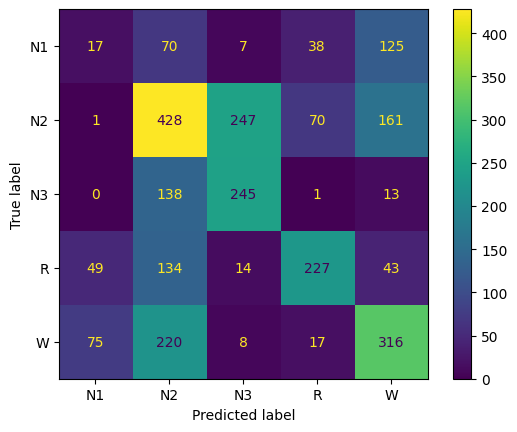

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
classes = np.unique(y_pred)
ConfusionMatrixDisplay.from_predictions(y, y_pred,
                                        display_labels=classes)
plt.show()

**(Part 7)** Calculate the overall accuracy of your model.

In [10]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y, y_pred)}')

Accuracy: 0.46283783783783783


**(Part 8)** What can you tell about your model based on these results? Is it particularly successful at classifying some sleep stages over others? Does it tend to get some stages confused with one another?

Write your answer here: Considering a random chance classifer would be approximately 20% accurate, we seem to be doing okay. As we can see from the diagnoal of our confusion matrix, the model is doing a decent job at correctly classifying stages W, N2, N3, and R. However, it is commonly confusing N1 for W and vice versa. This makes sense considering N1 is the lightest form of sleep and is therefore conceptually similar to W.

# Prepare Submission

To get full credit for this assignment, you should submit your assignment in two formats so that we can easily grade and debug your code:
1. **.ipynb:** First, confirm that your code can run from start to finish without any errors. To check this, go to "Runtime" > "Run all" in the Google Colab menu. If everything looks good, you can export your file by going to "File" > "Download" > "Download .ipynb".
2. **.pdf:** Run the function called `colab2pdf()` below. This will automatically convert your notebook to a PDF. Note that while "File" > "Print" > "Save as PDF" also works, it requires you to manually expand all of the cells and may cut off some images.

In [11]:
colab2pdf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>